https://publica-rest.fraunhofer.de/server/api/core/bitstreams/d4913d12-4cd1-473c-97cd-ed467ad19273/content

In [1]:
nodes_file = 'data/03_network-nodes.csv'
edges_file = 'data/04_network-edges.csv'

In [2]:
%pip install pandas networkx scipy lxml

  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 9.3 MB/s eta 0:00:000m eta 0:00:01:01:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 10.0 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached tzdata-2023.4-py2.py3-none-any.whl (346 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 KB 9.8 MB/s eta 0:00:0031m14.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


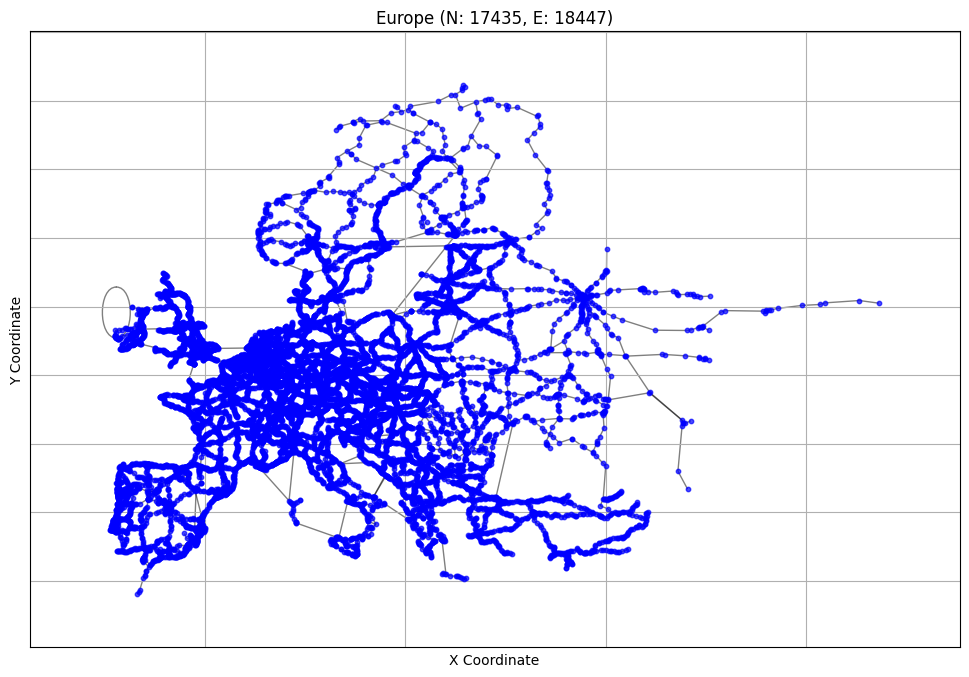

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Loading the Data
nodes_df = pd.read_csv(nodes_file)
edges_df = pd.read_csv(edges_file)

# Plot the graph
# Create a graph from the edges
G = nx.from_pandas_edgelist(edges_df, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in edges_df.iterrows():
    for column in edge_columns:
        G.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in nodes_df.iterrows()}

# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)

no_nodes = len(G.nodes)
no_edges = len(G.edges)

plt.title(f'Europe (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [4]:
nodes_df.head()

# unique values of the column country
nodes_df['Country'].unique()

array(['FR', 'ES', 'LU', 'PT', 'BE', 'NL', 'IT', 'DE', 'PL', 'DK', 'AT',
       'CH', 'LI', 'CZ', 'SI', 'HU', 'UK', 'IE', 'TR', 'RO', 'BG', 'GR',
       'MA', 'SK', 'RS', 'MK', 'HR', 'FI', 'SE', 'NO', 'LT', 'AL', 'BA',
       'UA', 'MD', 'BY', 'RU', 'LV', 'EE', 'AM', 'ME', 'KZ'], dtype=object)

In [5]:
edges_df.head()

,Unnamed: 0,Network_Edge_ID,Manually_Added,Distance,Network_Node_A_ID,Network_Node_B_ID,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030
0,0,2604457,0,5.980,262914,260432,0,0
1,1,1013364,0,18.559,262914,109845,0,0
2,2,2604243,0,2.012,262911,109968,1871252,2513351
3,3,1013595,0,4.728,262911,122766,1871252,2513351
4,4,2604354,0,15.028,262909,260001,1038691,1449368


In [6]:
country = 'BE'

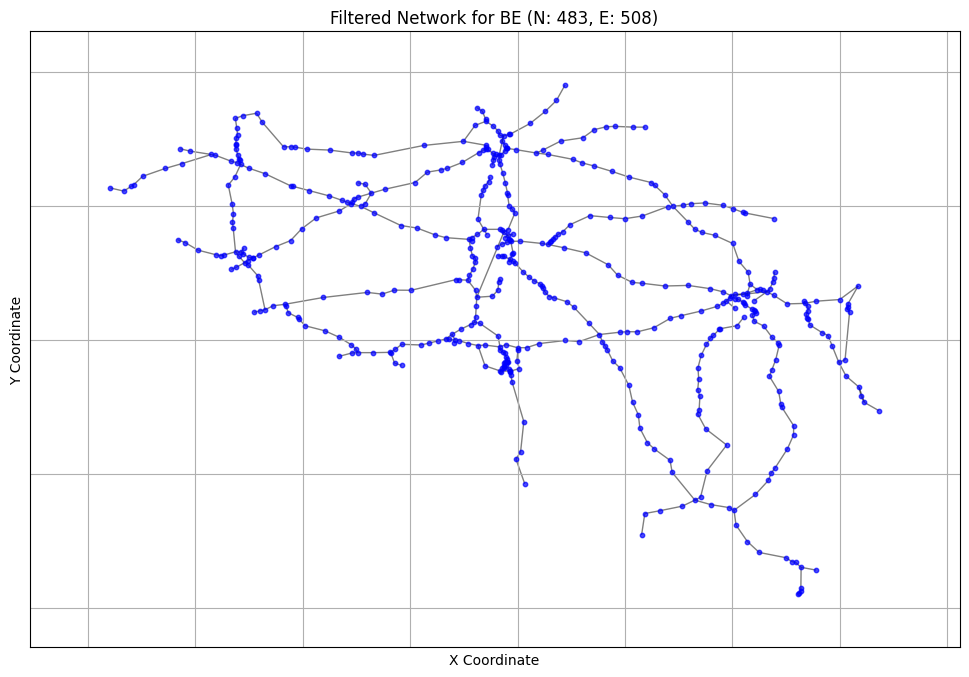

In [7]:
# 2. Filtering for a Specific Country 
filtered_nodes = nodes_df[nodes_df['Country'] == country]
filtered_edges = edges_df[edges_df['Network_Node_A_ID'].isin(filtered_nodes['Network_Node_ID']) & 
                        edges_df['Network_Node_B_ID'].isin(filtered_nodes['Network_Node_ID'])]


# Create a graph from the filtered edges
G_filtered = nx.from_pandas_edgelist(filtered_edges, 'Network_Node_A_ID', 'Network_Node_B_ID')

# add edge information as attributes to graph
edge_columns = ['Network_Edge_ID', 'Manually_Added', 'Distance', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030']
for index, row in filtered_edges.iterrows():
    for column in edge_columns:
        G_filtered.edges[row['Network_Node_A_ID'], row['Network_Node_B_ID']][column] = row[column]

# Create a position dictionary from node coordinates
pos_filtered = {row['Network_Node_ID']: (row['Network_Node_X'], row['Network_Node_Y']) for index, row in filtered_nodes.iterrows()}
# Plotting the network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_filtered, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_filtered, pos_filtered, alpha=0.5)

no_nodes = len(G_filtered.nodes)
no_edges = len(G_filtered.edges)

plt.title(f'Filtered Network for {country} (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()



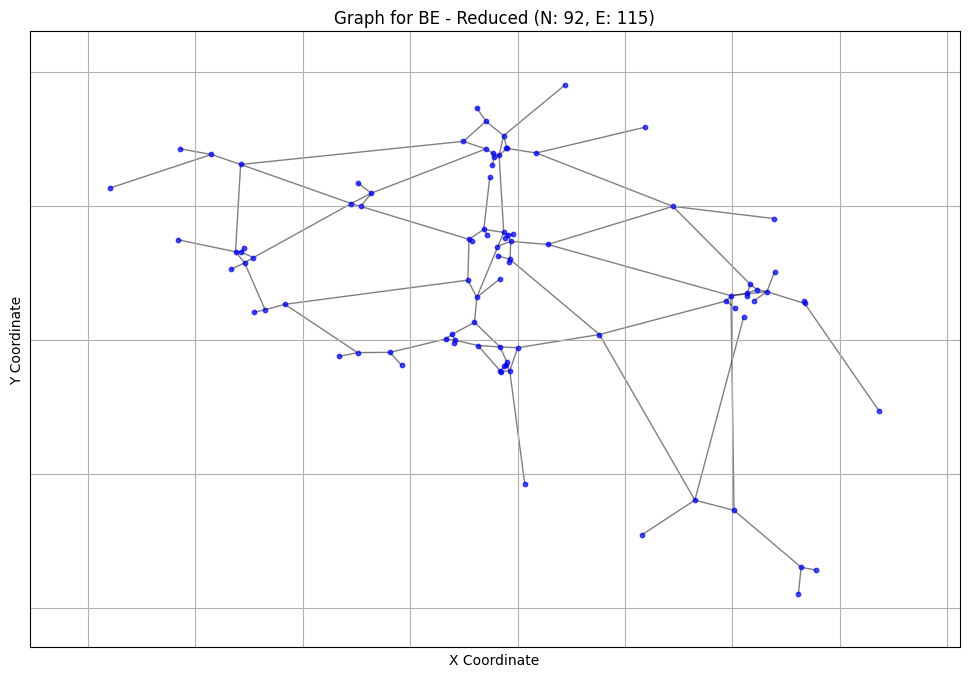

Number of nodes: 92
Number of edges: 115


In [8]:
import yaml

# 3. Iterative Reduction of Nodes
def remove_nodes_and_merge_edges(graph):    
    for edge in graph.edges():
        if 'original' not in graph.edges[edge]:
            graph.edges[edge]['original'] = True
            graph.edges[edge]['node_ids'] = []
            graph.edges[edge]['edge_ids'] = []

    # check that all edges have the original attribute
    assert all(['original' in graph.edges[edge] for edge in graph.edges()])


    while True:
        nodes_with_two_edges = [node for node, degree in dict(graph.degree()).items() if degree == 2]
        if not nodes_with_two_edges:
            break

        for node in nodes_with_two_edges:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) == 2:
                edge_1 = graph.edges[node, neighbors[0]]
                edge_2 = graph.edges[node, neighbors[1]]

                nodes = [node]
                if not edge_1['original']:
                    nodes += edge_1['node_ids']
                if not edge_2['original']:
                    nodes += edge_2['node_ids']	
                
                edges = []
                if not edge_1['original']:
                    edges += edge_1['edge_ids']
                else:
                    edges += [int(edge_1["Network_Edge_ID"])]

                if not edge_2['original']:
                    edges += edge_2['edge_ids']
                else:
                    edges += [int(edge_2["Network_Edge_ID"])]
                
                graph.remove_node(node)

                if not graph.has_edge(neighbors[0], neighbors[1]):
                    graph.add_edge(neighbors[0], neighbors[1])
                    graph.edges[neighbors[0], neighbors[1]]['Distance'] = float(edge_1['Distance'] + edge_2['Distance'])
                    graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                    graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                    graph.edges[neighbors[0], neighbors[1]]['original'] = False
                else:
                    # edge already exists, leave the closer one
                    edge_3 = graph.edges[neighbors[0], neighbors[1]]
                    if edge_1['Distance'] + edge_2['Distance'] < edge_3['Distance']:
                        graph.edges[neighbors[0], neighbors[1]]['Distance'] = edge_1['Distance'] + edge_2['Distance']
                        graph.edges[neighbors[0], neighbors[1]]['node_ids'] = nodes
                        graph.edges[neighbors[0], neighbors[1]]['edge_ids'] = edges
                        graph.edges[neighbors[0], neighbors[1]]['original'] = False

    new_edge_info = []
    id = 5_000_000# Highest id in dataset 2616216   
    for edge in graph.edges():
        if not graph.edges[edge]['original']:
            graph.edges[edge]['Network_Edge_ID'] = id
            edge_info = graph.edges[edge].copy()
            edge_info['Network_Node_A_ID'] = edge[0]
            edge_info['Network_Node_B_ID'] = edge[1]
            new_edge_info.append(edge_info)
            id += 1
        #del graph.edges[edge]['node_ids']
        #del graph.edges[edge]['edge_ids']

    return graph, new_edge_info

G_reduced, new_edge_info = remove_nodes_and_merge_edges(G_filtered.copy())

# 4. Store the Results
#nx.write_graphml_lxml(G_reduced, f'data/graph-{country}-reduced.graphml')

# store new edge information as yaml
with open(f'data/{country}new-edges-reduced.yaml', 'w') as file:
    yaml.dump(new_edge_info, file)

# 5. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced.nodes())
no_edges = len(G_reduced.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

print(f'Number of nodes: {no_nodes}')
print(f'Number of edges: {no_edges}')
    

In [9]:
threshold = 10

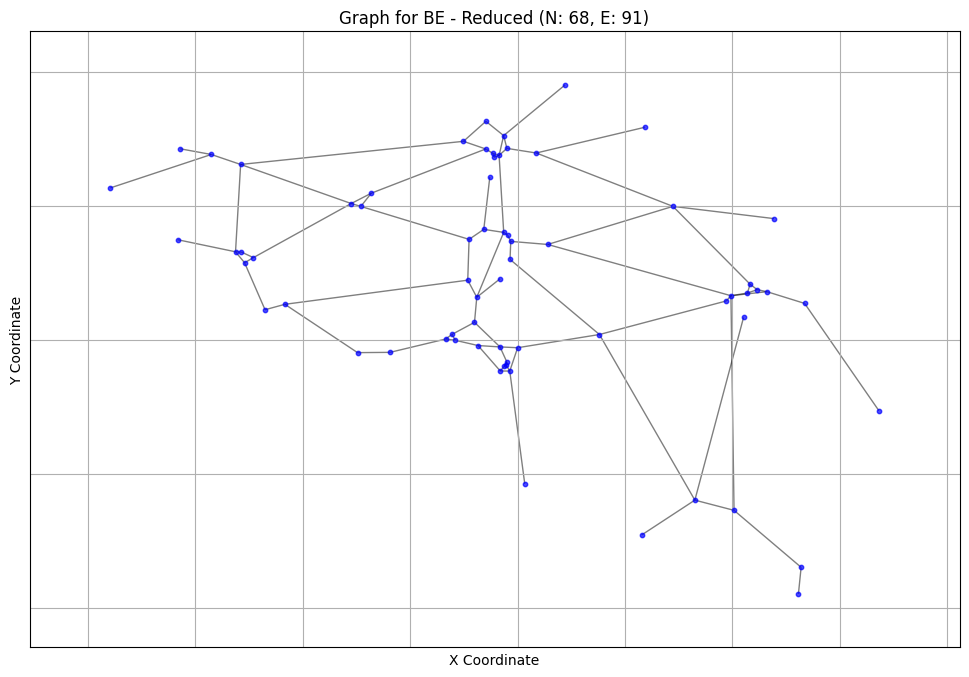

In [10]:
# remove nodes with degree 1 which have an edge with a distanve below threshold

def remove_nodes_with_degree_one(graph, threshold):
    nodes_to_remove = []
    for node in graph.nodes():
        if graph.degree(node) == 1:
            neighbor = list(graph.neighbors(node))[0]
            if graph.edges[node, neighbor]['Distance'] < threshold:
                nodes_to_remove.append(node)
    graph.remove_nodes_from(nodes_to_remove)
    return graph

G_reduced_2 = remove_nodes_with_degree_one(G_reduced.copy(), threshold)

# 6. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced_2, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced_2, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced_2.nodes())
no_edges = len(G_reduced_2.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

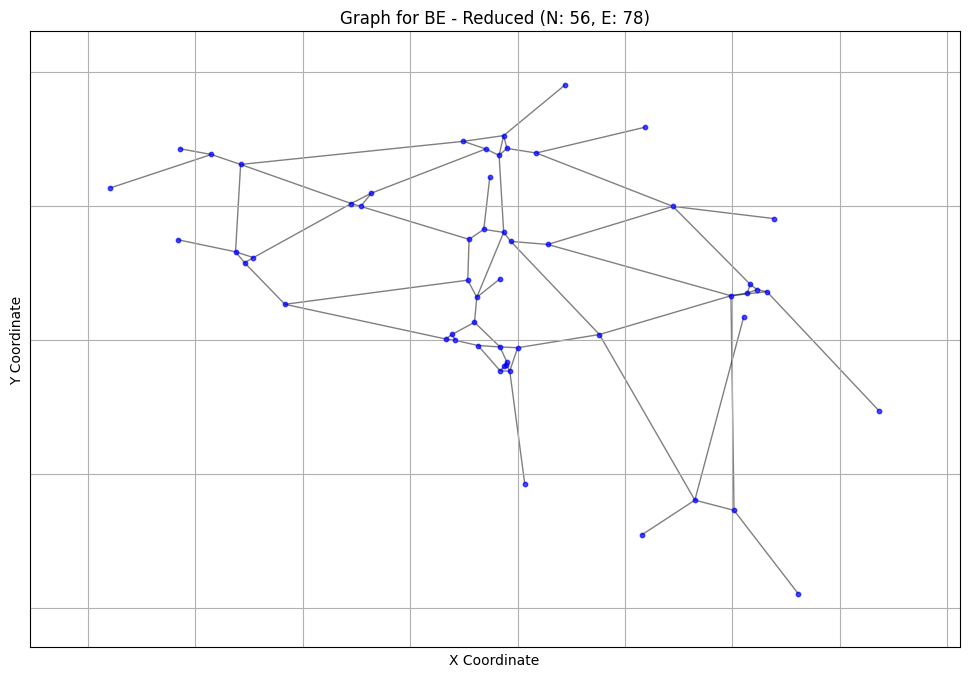

Number of nodes: 56
Number of edges: 78


In [11]:

G_reduced, new_edge_info = remove_nodes_and_merge_edges(G_reduced_2.copy())

# 4. Store the Results
#nx.write_graphml_lxml(G_reduced, f'data/graph-{country}-reduced.graphml')

# store new edge information as yaml
with open(f'data/{country}new-edges-reduced.yaml', 'w') as file:
    yaml.dump(new_edge_info, file)

# 5. Plot the Reduced Network
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_reduced, pos_filtered, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_reduced, pos_filtered, alpha=0.5)

no_nodes = len(G_reduced.nodes())
no_edges = len(G_reduced.edges())

plt.title(f'Graph for {country} - Reduced (N: {no_nodes}, E: {no_edges})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

print(f'Number of nodes: {no_nodes}')
print(f'Number of edges: {no_edges}')
    

In [12]:
segment_length = 10 # km

In [13]:
import numpy as np
total_number_of_segments = 0
for edge in G_reduced_2.edges():
    no_segments = int(np.ceil(G_reduced_2.edges[edge]['Distance'] / segment_length))
    G_reduced_2.edges[edge]['no_segments'] = no_segments
    total_number_of_segments += no_segments
    # print(f'Edge {edge} has {no_segments} segments')
print(f'Total number of segments: {total_number_of_segments}')

Total number of segments: 244


In [14]:
# load 02_NUTS-3-Regions.csv
nuts_regions_file = 'data/02_NUTS-3-Regions.csv'
nuts_regions_df = pd.read_csv(nuts_regions_file)

nuts_regions_df
# ETISPlus_Zone_ID	Name	Country	Geometric_center	Geometric_center_X	Geometric_center_Y	Network_Node_ID

,Unnamed: 0,ETISPlus_Zone_ID,Name,Country,Geometric_center,Geometric_center_X,Geometric_center_Y,Network_Node_ID
0,0,112090100,Guadeloupe,FR,POINT (-61.6763 16.1543),-61.6763,16.15430,106147
1,1,112090200,Martinique,FR,POINT (-61.02 14.636),-61.0200,14.63600,106147
2,2,112090300,French Guiana,FR,POINT (-53.0776 3.95175),-53.0776,3.95175,126354
3,3,127020000,Regiao Autonoma dos Acores,PT,POINT (-25.4934 37.8089),-25.4934,37.80890,106147
4,4,110070003,El Hierro,ES,POINT (-18.0221 27.7437),-18.0221,27.74370,185224
...,...,...,...,...,...,...,...,...
1670,1670,131000203,Nitriansky kraj,SK,POINT (18.3888 48.223),18.3880,48.22300,199617
1671,1671,131000301,Zilinsky kraj,SK,POINT (19.1917 49.1775),19.1917,49.17750,124253
1672,1672,131000302,Banskobystricky kraj,SK,POINT (19.4742 48.5005),19.4742,48.50050,199641
1673,1673,131000401,Presovsky kraj,SK,POINT (21.2239 49.112),21.2230,49.11200,199786


In [15]:
# Filter so only regions which are in the graph or are part of the reduced edges are left
nodes_in_graph = [row['Network_Node_ID'] for index, row in (nodes_df[nodes_df['Network_Node_ID'].isin(G_reduced_2.nodes())]).iterrows()]
# add nodes which have been removed during reduction
for edge in new_edge_info:
    nodes_in_graph += edge['node_ids']

#assert(len(nodes_in_graph) == len(set(nodes_in_graph)))
#assert(len(nodes_in_graph) == len(G_filtered.nodes()))
    
edges_in_graph = [row['Network_Edge_ID'] for index, row in (edges_df[edges_df['Network_Edge_ID'].isin(G_reduced_2.edges())]).iterrows()]

for edge in new_edge_info:
    edges_in_graph += edge['edge_ids']

regions_in_graph = nuts_regions_df[nuts_regions_df['Network_Node_ID'].isin(nodes_in_graph)]

# generate lookup table to convert from Zone ID to Network Node ID
zone_id_to_node_id_lookup = {row['ETISPlus_Zone_ID']: row['Network_Node_ID'] for index, row in regions_in_graph.iterrows()}

In [16]:
# load 01_Trucktrafficflow.csv
truck_traffic_file = 'data/01_Trucktrafficflow.csv'
truck_traffic_df = pd.read_csv(truck_traffic_file)

truck_traffic_df

,Unnamed: 0,ID_origin_region,Name_origin_region,ID_destination_region,Name_destination_region,Edge_path_E_road,Distance_from_origin_region_to_E_road,Distance_within_E_road,Distance_from_E_road_to_destination_region,Total_distance,Traffic_flow_trucks_2010,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030
0,0,101010101,Mittelburgenland,101010201,Mostviertel-Eisenwurzen,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,160.0,9.0,199.0,493.75,511.25,533.75,6715.0,6953.0,7259.0
1,1,101010101,Mittelburgenland,101010203,Sankt Polten,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,110.0,5.0,145.0,556.25,576.25,601.25,7565.0,7837.0,8177.0
2,2,101010101,Mittelburgenland,101010204,Waldviertel,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,166.0,11.0,207.0,472.50,490.00,511.25,6426.0,6664.0,6953.0
3,3,101010101,Mittelburgenland,101010205,Weinviertel,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,98.0,30.0,158.0,248.75,257.50,268.75,3383.0,3502.0,3655.0
4,4,101010101,Mittelburgenland,101010206,Wiener Umland/Nordteil,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,74.0,3.0,107.0,598.75,620.00,647.50,8143.0,8432.0,8806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514568,1514568,348080700,Chechnya,126060203,Elcki,"[1069947, 1069948, 1069949, 1069951, 1069960, ...",174.0,3081.0,195.0,3450.0,0.00,0.00,0.00,0.0,0.0,0.0
1514569,1514569,348080700,Chechnya,126060301,Slupski,"[1069947, 1069948, 1069949, 1069951, 1069960, ...",174.0,3406.0,35.0,3615.0,1.25,1.25,1.25,17.0,17.0,17.0
1514570,1514570,348080700,Chechnya,126060303,Trojmiejski,"[1069947, 1069948, 1069949, 1069951, 1069960, ...",174.0,3309.0,4.0,3487.0,1.25,1.25,1.25,17.0,17.0,17.0
1514571,1514571,348080700,Chechnya,126060304,Gdanski,"[1069947, 1069948, 1069949, 1069951, 1069960, ...",174.0,3350.0,13.0,3537.0,1.25,1.25,1.25,17.0,17.0,17.0


In [17]:
# parse all edge paths
from tqdm import tqdm
def parse_string_list_of_integer(string_list):
    if type(string_list) == str:
        if string_list == '[]':
            return []
        else:
            return [int(x) for x in string_list[1:-1].split(',')]
    else:
        pass

In [23]:

# filter trips to include only trips which have edges in the graph
both_in_graph = 0
truck_traffic_df['remove'] = True
truck_traffic_df['completly_in_graph'] = False

region_ids_in_graph = regions_in_graph['ETISPlus_Zone_ID'].to_list()
for index, row in tqdm(truck_traffic_df.iterrows(), total=len(truck_traffic_df)):
    path_edges = parse_string_list_of_integer(row['Edge_path_E_road'])
    found = False
    for edge in path_edges:
        if edge in edges_in_graph:
            truck_traffic_df.loc[index, 'remove'] = False
            found = True
            break

    if not found:
        continue

    # check if both regions are in the graph
    if row['ID_origin_region'] in region_ids_in_graph:
        truck_traffic_df.loc[index, 'origin_node'] =  int(zone_id_to_node_id_lookup[row['ID_origin_region']])
    else:
        # find first edge in the region 
        found = False
        for i, edge in enumerate(path_edges):
            if edge in edges_in_graph:
                edge_in = edge
                edge_out = path_edges[i-1]
                found = True
                break
        if not found:
            raise Exception('No edge in graph found')
            
        # find the node between the two edges
        edges_df_filtered = edges_df[edges_df['Network_Edge_ID'].isin([edge_in, edge_out])]
        nodes = [node for edge_node in ['Network_Node_A_ID', 'Network_Node_B_ID'] for node in edges_df_filtered[edge_node]]
        
        # find the node which is in the list twice
        for node in nodes:
            if nodes.count(node) == 2:
                node_between = node
                break

        truck_traffic_df.loc[index, 'origin_node'] = int(node_between)

    if row['ID_destination_region'] in region_ids_in_graph:
        truck_traffic_df.loc[index, 'destination_node'] =  int(zone_id_to_node_id_lookup[row['ID_destination_region']])
    else:
        found = False
        for i, edge in enumerate(path_edges[::-1]):
            if edge in edges_in_graph:
                edge_in = edge
                edge_out = path_edges[::-1][i-1]
                found = True
                break
        if not found:
            raise Exception('No edge in graph found')
        # find the node between the two edges
        edges_df_filtered = edges_df[edges_df['Network_Edge_ID'].isin([edge_in, edge_out])]
        nodes = [node for edge_node in ['Network_Node_A_ID', 'Network_Node_B_ID'] for node in edges_df_filtered[edge_node]]
        
        # find the node which is in the list twice
        for node in nodes:
            if nodes.count(node) == 2:
                node_between = node
                break
        truck_traffic_df.loc[index, 'destination_node'] = int(node_between)



truck_traffic_df_filtered = truck_traffic_df[~truck_traffic_df['remove']]

print(f'Number of trips edges in graph: {len(truck_traffic_df_filtered)} / {len(truck_traffic_df)}')

100%|██████████| 1514573/1514573 [40:03<00:00, 630.25it/s]  

Number of trips edges in graph: 321364 / 1514573


In [19]:
# remove trips which dont have any volume
truck_traffic_df_filtered

,Unnamed: 0,ID_origin_region,Name_origin_region,ID_destination_region,Name_destination_region,Edge_path_E_road,Distance_from_origin_region_to_E_road,Distance_within_E_road,Distance_from_E_road_to_destination_region,Total_distance,Traffic_flow_trucks_2010,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030,remove,completly_in_graph,origin_node,destination_node
31,31,101010101,Mittelburgenland,102020101,Arr. Antwerpen,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1152.0,4.0,1186.0,2.50,2.50,3.75,34.0,34.0,51.0,False,False,111186.0,111055.0
32,32,101010101,Mittelburgenland,102020102,Arr. Mechelen,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1160.0,6.0,1196.0,0.00,0.00,0.00,0.0,0.0,0.0,False,False,111186.0,195887.0
33,33,101010101,Mittelburgenland,102020201,Arr. Hasselt,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1093.0,1.0,1124.0,0.00,0.00,0.00,0.0,0.0,0.0,False,False,106932.0,106828.0
34,34,101010101,Mittelburgenland,102020304,Arr. Gent,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1206.0,5.0,1241.0,1.25,1.25,1.25,17.0,17.0,17.0,False,False,111186.0,111270.0
35,35,101010101,Mittelburgenland,102020501,Arr. Brugge,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1247.0,3.0,1280.0,0.00,0.00,0.00,0.0,0.0,0.0,False,False,111186.0,111433.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482276,1482276,133230005,West and South of Northern Ireland,131000203,Nitriansky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2482.0,14.0,2528.0,148.75,310.00,760.00,2023.0,4216.0,10336.0,False,False,181083.0,111186.0
1482277,1482277,133230005,West and South of Northern Ireland,131000301,Zilinsky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2486.0,7.0,2525.0,148.75,310.00,761.25,2023.0,4216.0,10353.0,False,False,181083.0,195913.0
1482278,1482278,133230005,West and South of Northern Ireland,131000302,Banskobystricky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2525.0,2.0,2559.0,100.00,208.75,510.00,1360.0,2839.0,6936.0,False,False,181083.0,111186.0
1482279,1482279,133230005,West and South of Northern Ireland,131000401,Presovsky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2660.0,11.0,2703.0,108.75,227.50,556.25,1479.0,3094.0,7565.0,False,False,181083.0,195913.0


In [20]:
# Create reduced graph node lookup table
new_edge_info_lookup = {}
new_node_info_lookup = {}

for edge in new_edge_info:
    for node in edge['node_ids']:
        new_edge_info_lookup[node] = edge['Network_Edge_ID']
        new_node_info_lookup[node] = [edge[ab] for ab in ['Network_Node_A_ID', 'Network_Node_B_ID']]

nodes_in_reduced_graph = [node for node in G_reduced_2.nodes() ]

In [25]:
for index, row in truck_traffic_df_filtered.iterrows():
    origin_node = int(row['origin_node'])
    destination_node = int(row['destination_node'])
    
    if origin_node not in nodes_in_reduced_graph:
        origin_node = new_node_info_lookup[origin_node][0]
    if destination_node not in nodes_in_reduced_graph:
        destination_node = new_node_info_lookup[destination_node][1]
    truck_traffic_df_filtered.loc[index, 'origin_node_reduced'] = origin_node
    truck_traffic_df_filtered.loc[index, 'destination_node_reduced'] = destination_node
    

In [34]:
truck_traffic_df_filtered

,Unnamed: 0,ID_origin_region,Name_origin_region,ID_destination_region,Name_destination_region,Edge_path_E_road,Distance_from_origin_region_to_E_road,Distance_within_E_road,Distance_from_E_road_to_destination_region,Total_distance,...,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030,remove,completly_in_graph,origin_node,destination_node,origin_node_reduced,destination_node_reduced
0,31,101010101,Mittelburgenland,102020101,Arr. Antwerpen,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1152.0,4.0,1186.0,...,3.75,34.0,34.0,51.0,False,False,111186.0,111055.0,111186.0,111077.0
1,32,101010101,Mittelburgenland,102020102,Arr. Mechelen,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1160.0,6.0,1196.0,...,0.00,0.0,0.0,0.0,False,False,111186.0,195887.0,111186.0,111084.0
2,33,101010101,Mittelburgenland,102020201,Arr. Hasselt,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1093.0,1.0,1124.0,...,0.00,0.0,0.0,0.0,False,False,106932.0,106828.0,106932.0,111208.0
3,34,101010101,Mittelburgenland,102020304,Arr. Gent,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1206.0,5.0,1241.0,...,1.25,17.0,17.0,17.0,False,False,111186.0,111270.0,111186.0,111283.0
4,35,101010101,Mittelburgenland,102020501,Arr. Brugge,"[1034974, 1008535, 1008552, 1000001, 1008851, ...",30.0,1247.0,3.0,1280.0,...,0.00,0.0,0.0,0.0,False,False,111186.0,111433.0,111186.0,111052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321359,1482276,133230005,West and South of Northern Ireland,131000203,Nitriansky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2482.0,14.0,2528.0,...,760.00,2023.0,4216.0,10336.0,False,False,181083.0,111186.0,181083.0,111186.0
321360,1482277,133230005,West and South of Northern Ireland,131000301,Zilinsky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2486.0,7.0,2525.0,...,761.25,2023.0,4216.0,10353.0,False,False,181083.0,195913.0,181083.0,195913.0
321361,1482278,133230005,West and South of Northern Ireland,131000302,Banskobystricky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2525.0,2.0,2559.0,...,510.00,1360.0,2839.0,6936.0,False,False,181083.0,111186.0,181083.0,111186.0
321362,1482279,133230005,West and South of Northern Ireland,131000401,Presovsky kraj,"[1025630, 1031522, 1031516, 1034642, 1025629, ...",32.0,2660.0,11.0,2703.0,...,556.25,1479.0,3094.0,7565.0,False,False,181083.0,195913.0,181083.0,195913.0


In [35]:
# clean data before exporting
#change datatype of [origin_node	destination_node	origin_node_reduced	destination_node_reduced] to int
change = ['origin_node', 'destination_node', 'origin_node_reduced', 'destination_node_reduced']
for column in change:
    truck_traffic_df_filtered[column] = truck_traffic_df_filtered[column].astype(int)

#drop columns
drop = ['remove', 'completly_in_graph', 'Edge_path_E_road', 'Distance_from_origin_region_to_E_road', 'Distance_within_E_road', 'Distance_from_E_road_to_destination_region', 'Total_distance']
truck_traffic_df_filtered = truck_traffic_df_filtered.drop(drop, axis=1)

In [40]:
# sort origin_node_reduced and destination_node_reduced by id (The order of origin destination are irrelevant for the traffic assignment. So this reduces the number of duplicates)
for index, row in truck_traffic_df_filtered.iterrows():
    if row['origin_node_reduced'] > row['destination_node_reduced']:
        truck_traffic_df_filtered.loc[index, 'origin_node_reduced'], truck_traffic_df_filtered.loc[index, 'destination_node_reduced'] = row['destination_node_reduced'], row['origin_node_reduced']


# aggregate duplicates (same origin and destination) by adding up the volume
# Traffic_flow_trucks_2010	Traffic_flow_trucks_2019	Traffic_flow_trucks_2030	Traffic_flow_tons_2010	Traffic_flow_tons_2019	Traffic_flow_tons_2030
truck_traffic_df_filtered = truck_traffic_df_filtered.groupby(['origin_node_reduced', 'destination_node_reduced']).agg({'Traffic_flow_trucks_2010': 'sum', 'Traffic_flow_trucks_2019': 'sum', 'Traffic_flow_trucks_2030': 'sum', 'Traffic_flow_tons_2010': 'sum', 'Traffic_flow_tons_2019': 'sum', 'Traffic_flow_tons_2030': 'sum'}).reset_index()

# remove rows where origin_node_reduced == destination_node_reduced
truck_traffic_df_filtered = truck_traffic_df_filtered[truck_traffic_df_filtered['origin_node_reduced'] != truck_traffic_df_filtered['destination_node_reduced']]

# remove rows where all Traffic_flow_trucks and Traffic_flow_tons are 0
truck_traffic_df_filtered = truck_traffic_df_filtered[(truck_traffic_df_filtered[['Traffic_flow_trucks_2010', 'Traffic_flow_trucks_2019', 'Traffic_flow_trucks_2030', 'Traffic_flow_tons_2010', 'Traffic_flow_tons_2019', 'Traffic_flow_tons_2030']] != 0).any(axis=1)]

# rename origin_node_reduced and destination_node_reduced to origin and destination
truck_traffic_df_filtered = truck_traffic_df_filtered.rename(columns={'origin_node_reduced': 'origin', 'destination_node_reduced': 'destination'})

In [41]:
truck_traffic_df_filtered

,origin,destination,Traffic_flow_trucks_2010,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,Traffic_flow_tons_2010,Traffic_flow_tons_2019,Traffic_flow_tons_2030
0,100268,106843,3436.25,3833.75,4386.25,46733.0,52139.0,59653.0
1,100268,106882,43.75,48.75,57.50,595.0,663.0,782.0
2,100268,106892,127.50,143.75,167.50,1734.0,1955.0,2278.0
3,100268,106932,89831.25,112123.75,149797.50,1221705.0,1524883.0,2037246.0
4,100268,106940,33458.75,37338.75,42712.50,455039.0,507807.0,580890.0
...,...,...,...,...,...,...,...,...
823,181085,195727,2502.50,2425.00,2332.50,34034.0,32980.0,31722.0
824,181085,195913,23991.25,27821.25,34137.50,326281.0,378369.0,464270.0
825,181085,195938,71550.00,77873.75,87098.75,973080.0,1059083.0,1184543.0
826,195727,195938,2467.50,2747.50,3150.00,33558.0,37366.0,42840.0


In [43]:
# export to csv
truck_traffic_df_filtered.to_csv(f'data/01_Trucktrafficflow_filtered_{country}.csv', index=False)